# JOB-A-THON - September 2021

## Submitted by - Nitin Rajput

- **Objective** :  to predict the store sales for each store in the test set for the next two months
- **Dependent variable** : Sales
- **Independent variables** : ID, Store_id, Store_Type, Location_Type, Region_Code	Date, Holiday, Discount, #Order

In [1]:
#Importing necesaary libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data preparation

# loading files
df_train=pd.read_csv("TRAIN.csv")
df_test=pd.read_csv("TEST_FINAL.csv")

# changing datatype of date to extract more features 
df_train['Date']=pd.to_datetime(df_train['Date'])
df_test['Date']=pd.to_datetime(df_test['Date'])

# log transformation of sales to avoid negative prediction of sales
# final prediction wil be converted back with the help of np.expm1
df_train['Sales']=np.log1p(df_train['Sales'])

In [4]:
# converting categorical features using pd.get_dummies in onehot encoding
df_train=pd.get_dummies(df_train,columns=['Store_Type','Location_Type','Discount','Region_Code'],drop_first=True)
df_test=pd.get_dummies(df_test,columns=['Store_Type','Location_Type','Discount','Region_Code'],drop_first=True)

In [5]:
# extracting new features from Date column
# Sales show some monthly, weekly and monthday wise seasonal pattern so these features are pretty useful
df_train['month']=df_train['Date'].dt.month
df_train['weekday']=df_train['Date'].dt.dayofweek
df_train['Day']=df_train['Date'].dt.day


df_test['month']=df_test['Date'].dt.month
df_test['weekday']=df_test['Date'].dt.dayofweek
df_test['Day']=df_test['Date'].dt.day

In [6]:
# creating a fold columns in training data using 5 folds
# This will help in cross validation as well as in stacking later
df_train['kfold']=-1

folds=KFold(n_splits=5,shuffle=True,random_state=41)
for fold,(train_index,test_index) in enumerate(folds.split(df_train)):
    df_train.loc[test_index, 'kfold']=fold

For modeling purpose, we will use stacking method with 4 models in layer 1 and 1 model in layer 2.
- model1- xgboost(handpicked parameters)
- model2- xgboost(hypertuned parameters, pretuned with optuna)
- model3- catboost(hypertuned parameters, pretuned with optuna)
- model4- lightgbm(handpicked parameters/manually tuned)
- stacking model- LinearRegression

## layer 1

### model1 xgboost

In [7]:
#xgb
sample=pd.read_csv("SAMPLE.csv")

# dropping id- unique for each row
# dropping Date- already extracted necessary features
# dropping #Order- no such column in test data, leads to data leakage as it is highly corelated to sales
features=[col for col in df_test.columns if col not in ['ID','#Order','Date']]

test=df_test[features]

model=XGBRegressor(n_estimators=5000,
                    random_state=41,
                    learning_rate=0.01,
                    n_jobs=-1,
                    tree_method='gpu_hist', 
                    predictor="gpu_predictor")

val_score=[]
training_score=[]
final_test_predictions=[]
final_valid_predictions={}
for i in range(5):
    xtrain=df_train[df_train.kfold!=i].reset_index(drop=True)
    xvalid=df_train[df_train.kfold==i].reset_index(drop=True)
    xtest=test.copy()
    
    valid_ids = xvalid.ID.values.tolist()
    
    ytrain=xtrain['Sales']
    yvalid=xvalid['Sales']
    
    xtrain=xtrain[features]
    xvalid=xvalid[features]
    
    model.fit(xtrain, ytrain, 
              eval_metric="rmse",
              early_stopping_rounds=200, 
              eval_set=[(xvalid, yvalid)], 
              verbose=1000)
    
    valid_pred=model.predict(xvalid)
    test_pred=model.predict(xtest)
    train_pred=model.predict(xtrain)
    
    final_test_predictions.append(test_pred)
    final_valid_predictions.update(dict(zip(valid_ids,valid_pred)))
    
    val_score.append(mean_squared_error(yvalid,valid_pred)*1000)
    training_score.append(mean_squared_error(ytrain,train_pred)*1000)
    
    # Using metric MSE as target column is already log transformed
    # So MSE will give us MSLE
    print(f"validation error of fold {i}",mean_squared_error(yvalid,valid_pred)*1000)
    print(f"training error of fold {i}",mean_squared_error(ytrain,train_pred)*1000)

print("----------------------------------------")   
print("mean validation error: ",sum(val_score)/len(val_score))
print("mean training error: ",sum(training_score)/len(training_score))

# OOF predictions
# These will we used as input of training data for stacking in layer 2
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["ID", "pred_1"]

final_valid_predictions.to_csv("train_pred_1.csv", index=False)

# Test data prediction from model 1
# These will be used as input of test data in layer 2
# As there are 5 test predictions due to 5 folds, mean of all the 5 predictions is taken
sample['Sales']=np.mean(np.column_stack(final_test_predictions),axis=1)
sample.columns=['ID','pred_1']

sample.to_csv("test_pred_1.csv", index=False)

[0]	validation_0-rmse:9.97817
[1000]	validation_0-rmse:0.23094
[2000]	validation_0-rmse:0.22024
[3000]	validation_0-rmse:0.21576
[4000]	validation_0-rmse:0.21390
[4999]	validation_0-rmse:0.21256
validation error of fold 0 45.18227271415521
training error of fold 0 38.96046541055136
[0]	validation_0-rmse:9.97780
[1000]	validation_0-rmse:0.22405
[2000]	validation_0-rmse:0.21303
[3000]	validation_0-rmse:0.20836
[4000]	validation_0-rmse:0.20626
[4999]	validation_0-rmse:0.20513
validation error of fold 1 42.07760030071928
training error of fold 1 39.24355361536774
[0]	validation_0-rmse:9.97548
[1000]	validation_0-rmse:0.23051
[2000]	validation_0-rmse:0.21966
[3000]	validation_0-rmse:0.21483
[4000]	validation_0-rmse:0.21247
[4999]	validation_0-rmse:0.21139
validation error of fold 2 44.66556829692589
training error of fold 2 37.79142968833778
[0]	validation_0-rmse:9.98247
[1000]	validation_0-rmse:0.23243
[2000]	validation_0-rmse:0.22161
[3000]	validation_0-rmse:0.21721
[4000]	validation_0-rm

### model2 xgboost(hypertuned)

In [8]:
#XGB
sample=pd.read_csv("SAMPLE.csv")

features=[col for col in df_test.columns if col not in ['ID','#Order','Date']]

test=df_test[features]

params_xgb2={'n_estimators': 7991,
             'max_depth': 9,
             'learning_rate': 0.024603035980196343,
             'gamma': 0.1,
             'min_child_weight': 7,
             'subsample': 0.69,
             'colsample_bytree': 0.89,
             'reg_alpha': 1.01,
             'reg_lambda': 5.66}

model=XGBRegressor(**params_xgb2,
                   random_state=41,
                   n_jobs=-1,
                   tree_method='gpu_hist', 
                   predictor="gpu_predictor")

val_score=[]
training_score=[]
final_test_predictions=[]
final_valid_predictions={}
for i in range(5):
    xtrain=df_train[df_train.kfold!=i].reset_index(drop=True)
    xvalid=df_train[df_train.kfold==i].reset_index(drop=True)
    xtest=test.copy()
    
    valid_ids = xvalid.ID.values.tolist()
    
    ytrain=xtrain['Sales']
    yvalid=xvalid['Sales']
    
    xtrain=xtrain[features]
    xvalid=xvalid[features]
    
    model.fit(xtrain, ytrain, 
              eval_metric="rmse",
              early_stopping_rounds=200, 
              eval_set=[(xvalid, yvalid)], 
              verbose=1000)
    
    valid_pred=model.predict(xvalid)
    test_pred=model.predict(xtest)
    train_pred=model.predict(xtrain)
    
    final_test_predictions.append(test_pred)
    final_valid_predictions.update(dict(zip(valid_ids,valid_pred)))
    
    val_score.append(mean_squared_error(yvalid,valid_pred)*1000)
    training_score.append(mean_squared_error(ytrain,train_pred)*1000)
    
    print(f"validation error of fold {i}",mean_squared_error(yvalid,valid_pred)*1000)
    print(f"training error of fold {i}",mean_squared_error(ytrain,train_pred)*1000)

print("----------------------------------------")   
print("mean validation error: ",sum(val_score)/len(val_score))
print("mean training error: ",sum(training_score)/len(training_score))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["ID", "pred_2"]

final_valid_predictions.to_csv("train_pred_2.csv", index=False)

sample['Sales']=np.mean(np.column_stack(final_test_predictions),axis=1)
sample.columns=['ID','pred_2']

sample.to_csv("test_pred_2.csv", index=False)

[0]	validation_0-rmse:9.83131
[1000]	validation_0-rmse:0.21193
[2000]	validation_0-rmse:0.21100
[3000]	validation_0-rmse:0.21067
[4000]	validation_0-rmse:0.21052
[4989]	validation_0-rmse:0.21039
validation error of fold 0 44.260455427043446
training error of fold 0 38.21002204225124
[0]	validation_0-rmse:9.83089
[1000]	validation_0-rmse:0.20459
[2000]	validation_0-rmse:0.20367
[3000]	validation_0-rmse:0.20329
[3834]	validation_0-rmse:0.20317
validation error of fold 1 41.27492250353167
training error of fold 1 39.32167943107379
[0]	validation_0-rmse:9.82863
[1000]	validation_0-rmse:0.21099
[2000]	validation_0-rmse:0.20992
[3000]	validation_0-rmse:0.20962
[4000]	validation_0-rmse:0.20939
[4251]	validation_0-rmse:0.20938
validation error of fold 2 43.84019314930321
training error of fold 2 38.286452657478016
[0]	validation_0-rmse:9.83562
[1000]	validation_0-rmse:0.21325
[2000]	validation_0-rmse:0.21213
[3000]	validation_0-rmse:0.21167
[3247]	validation_0-rmse:0.21166
validation error of 

### model3 Catboost

In [9]:
#ctb
sample=pd.read_csv("SAMPLE.csv")

features=[col for col in df_test.columns if col not in ['ID','#Order','Date']]

test=df_test[features]

params_ctb1={'iterations': 19123,
             'depth': 9,
             'learning_rate': 0.030515071017984265,
             'reg_lambda': 17.3,
             'eval_metric':'RMSE',
             'verbose':False,
             'task_type':'GPU'}

model=CatBoostRegressor(**params_ctb1,
                           random_seed=41)

val_score=[]
training_score=[]
final_test_predictions=[]
final_valid_predictions={}
for i in range(5):
    xtrain=df_train[df_train.kfold!=i].reset_index(drop=True)
    xvalid=df_train[df_train.kfold==i].reset_index(drop=True)
    xtest=test.copy()
    
    valid_ids = xvalid.ID.values.tolist()
    
    ytrain=xtrain['Sales']
    yvalid=xvalid['Sales']
    
    xtrain=xtrain[features]
    xvalid=xvalid[features]
    
    model.fit(xtrain, ytrain, 
              early_stopping_rounds=200, 
              eval_set=[(xvalid, yvalid)], 
              verbose=2000)
    
    valid_pred=model.predict(xvalid)
    test_pred=model.predict(xtest)
    train_pred=model.predict(xtrain)
    
    final_test_predictions.append(test_pred)
    final_valid_predictions.update(dict(zip(valid_ids,valid_pred)))
    
    val_score.append(mean_squared_error(yvalid,valid_pred)*1000)
    training_score.append(mean_squared_error(ytrain,train_pred)*1000)
    
    print(f"validation error of fold {i}",mean_squared_error(yvalid,valid_pred)*1000)
    print(f"training error of fold {i}",mean_squared_error(ytrain,train_pred)*1000)

print("----------------------------------------")   
print("mean validation error: ",sum(val_score)/len(val_score))
print("mean training error: ",sum(training_score)/len(training_score))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["ID", "pred_3"]

final_valid_predictions.to_csv("train_pred_3.csv", index=False)

sample['Sales']=np.mean(np.column_stack(final_test_predictions),axis=1)
sample.columns=['ID','pred_3']

sample.to_csv("test_pred_3.csv", index=False)

0:	learn: 0.4653105	test: 0.4635419	best: 0.4635419 (0)	total: 13.8ms	remaining: 4m 23s
2000:	learn: 0.1991006	test: 0.2135372	best: 0.2135372 (2000)	total: 16.8s	remaining: 2m 23s
4000:	learn: 0.1851558	test: 0.2115387	best: 0.2114976 (3956)	total: 33.3s	remaining: 2m 5s
bestTest = 0.2114976309
bestIteration = 3956
Shrink model to first 3957 iterations.
validation error of fold 0 44.73124218373251
training error of fold 0 34.38018742997649
0:	learn: 0.4653997	test: 0.4632191	best: 0.4632191 (0)	total: 9.29ms	remaining: 2m 57s
2000:	learn: 0.2014890	test: 0.2058289	best: 0.2058289 (2000)	total: 16.5s	remaining: 2m 21s
4000:	learn: 0.1882522	test: 0.2030398	best: 0.2030398 (4000)	total: 33.2s	remaining: 2m 5s
bestTest = 0.2024415463
bestIteration = 5632
Shrink model to first 5633 iterations.
validation error of fold 1 40.98261142685153
training error of fold 1 32.75101813967912
0:	learn: 0.4638263	test: 0.4695832	best: 0.4695832 (0)	total: 9.39ms	remaining: 2m 59s
2000:	learn: 0.1998876

### model4 lightgbm

In [10]:
#lgb
sample=pd.read_csv("SAMPLE.csv")

features=[col for col in df_test.columns if col not in ['ID','#Order','Date']]

test=df_test[features]

model=LGBMRegressor(random_state=41,
                   n_estimators=15000,
                   learning_rate=0.05,
                   reg_alpha=3.1,
                   device = 'gpu',
                   n_jobs=-1)

val_score=[]
training_score=[]
final_test_predictions=[]
final_valid_predictions={}
for i in range(5):
    xtrain=df_train[df_train.kfold!=i].reset_index(drop=True)
    xvalid=df_train[df_train.kfold==i].reset_index(drop=True)
    xtest=test.copy()
    
    valid_ids = xvalid.ID.values.tolist()
    
    ytrain=xtrain['Sales']
    yvalid=xvalid['Sales']
    
    xtrain=xtrain[features]
    xvalid=xvalid[features]
    
    model.fit(xtrain, ytrain, 
              eval_metric="rmse",
              early_stopping_rounds=200, 
              eval_set=[(xvalid, yvalid)], 
              verbose=1000)
    
    valid_pred=model.predict(xvalid)
    test_pred=model.predict(xtest)
    train_pred=model.predict(xtrain)
    
    final_test_predictions.append(test_pred)
    final_valid_predictions.update(dict(zip(valid_ids,valid_pred)))
    
    val_score.append(mean_squared_error(yvalid,valid_pred)*1000)
    training_score.append(mean_squared_error(ytrain,train_pred)*1000)
    
    print(f"validation error of fold {i}",mean_squared_error(yvalid,valid_pred)*1000)
    print(f"training error of fold {i}",mean_squared_error(ytrain,train_pred)*1000)

print("----------------------------------------")   
print("mean validation error: ",sum(val_score)/len(val_score))
print("mean training error: ",sum(training_score)/len(training_score))

final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["ID", "pred_4"]

final_valid_predictions.to_csv("train_pred_4.csv", index=False)

sample['Sales']=np.mean(np.column_stack(final_test_predictions),axis=1)
sample.columns=['ID','pred_4']

sample.to_csv("test_pred_4.csv", index=False)

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.213419	valid_0's l2: 0.0455477
[2000]	valid_0's rmse: 0.210402	valid_0's l2: 0.0442689
[3000]	valid_0's rmse: 0.209543	valid_0's l2: 0.0439082
Early stopping, best iteration is:
[3482]	valid_0's rmse: 0.209371	valid_0's l2: 0.0438363
validation error of fold 0 43.836253759173815
training error of fold 0 35.096441806334084
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.205589	valid_0's l2: 0.0422669
[2000]	valid_0's rmse: 0.201004	valid_0's l2: 0.0404026
[3000]	valid_0's rmse: 0.199466	valid_0's l2: 0.0397868
Early stopping, best iteration is:
[3367]	valid_0's rmse: 0.199216	valid_0's l2: 0.039687
validation error of fold 1 39.68696948471152
training error of fold 1 36.30669204567961
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.21286	valid_0's l2: 0.0453092
[2000]	valid_0's rmse: 0.208177	valid_0's l2: 0.0433378
[3000]	v

### Preparing the data for layer 2

In [11]:
test=pd.read_csv("TEST_FINAL.csv")

# reading oof predictions from layer1
df1=pd.read_csv("train_pred_1.csv")
df2=pd.read_csv("train_pred_2.csv")
df3=pd.read_csv("train_pred_3.csv")
df4=pd.read_csv("train_pred_4.csv")

# reading test predictions from layer1
df_test1=pd.read_csv("test_pred_1.csv")
df_test2=pd.read_csv("test_pred_2.csv")
df_test3=pd.read_csv("test_pred_3.csv")
df_test4=pd.read_csv("test_pred_4.csv")

# merging oof predictions with original training set
df_train=df_train.merge(df1, on="ID", how="left")
df_train=df_train.merge(df2, on="ID", how="left")
df_train=df_train.merge(df3, on="ID", how="left")
df_train=df_train.merge(df4, on="ID", how="left")

# merging test predictions from layer1 with original testing set
test=test.merge(df_test1, on="ID", how="left")
test=test.merge(df_test2, on="ID", how="left")
test=test.merge(df_test3, on="ID", how="left")
test=test.merge(df_test4, on="ID", how="left")


df_train.head()

,ID,Store_id,Date,Holiday,#Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,...,Region_Code_R3,Region_Code_R4,month,weekday,Day,kfold,pred_1,pred_2,pred_3,pred_4
0,T1000001,1,2018-01-01,1,9,8.855498,0,0,0,0,...,0,0,1,0,1,0,10.561811,10.541957,10.519053,10.383783
1,T1000002,253,2018-01-01,1,60,10.854955,0,0,1,1,...,0,0,1,0,1,1,10.512292,10.561481,10.462519,10.558485
2,T1000003,252,2018-01-01,1,42,10.515132,0,1,0,1,...,0,0,1,0,1,3,10.739979,10.724936,10.710727,10.702884
3,T1000004,251,2018-01-01,1,23,9.889194,1,0,0,0,...,0,0,1,0,1,0,10.683091,10.691403,10.729571,10.679597
4,T1000005,250,2018-01-01,1,62,10.728003,1,0,0,0,...,0,1,1,0,1,2,10.434593,10.490993,10.479087,10.478425


## layer 2

### Linear Regression

In [12]:
#linear regression
sample=pd.read_csv("SAMPLE.csv")

# selecting predictions of previous layer as input features
features=["pred_1","pred_2","pred_3",'pred_4']

df_test=test[features]

model=LinearRegression()

val_score=[]
training_score=[]
final_test_predictions=[]

for i in range(5):
    xtrain=df_train[df_train.kfold!=i].reset_index(drop=True)
    xvalid=df_train[df_train.kfold==i].reset_index(drop=True)
    xtest=df_test.copy()
        
    ytrain=xtrain['Sales']
    yvalid=xvalid['Sales']
    
    xtrain=xtrain[features]
    xvalid=xvalid[features]
    
    model.fit(xtrain, ytrain)
    
    valid_pred=model.predict(xvalid)
    test_pred=model.predict(xtest)
    train_pred=model.predict(xtrain)
    
    # converting log predicted values back to original scale using np.expm1
    final_test_predictions.append(np.expm1(test_pred))
    
    val_score.append(mean_squared_error(yvalid,valid_pred)*1000)
    training_score.append(mean_squared_error(ytrain,train_pred)*1000)
    
    print(f"validation error of fold {i}",mean_squared_error(yvalid,valid_pred)*1000)
    print(f"training error of fold {i}",mean_squared_error(ytrain,train_pred)*1000)

print("----------------------------------------")   
print("mean validation error: ",sum(val_score)/len(val_score))
print("mean training error: ",sum(training_score)/len(training_score))

validation error of fold 0 43.50988822940696
training error of fold 0 42.3995003009689
validation error of fold 1 39.50225547388177
training error of fold 1 43.40140389581971
validation error of fold 2 42.81128973206908
training error of fold 2 42.57290337922226
validation error of fold 3 43.76736597818316
training error of fold 3 42.33293464039773
validation error of fold 4 43.6453449710406
training error of fold 4 42.373121293993336
----------------------------------------
mean validation error:  42.647228876916316
mean training error:  42.615972702080384


In [13]:
sample['Sales']=np.mean(np.column_stack(final_test_predictions),axis=1)

sample.to_csv("sub23.csv", index=False)

<AxesSubplot:xlabel='Sales', ylabel='Density'>

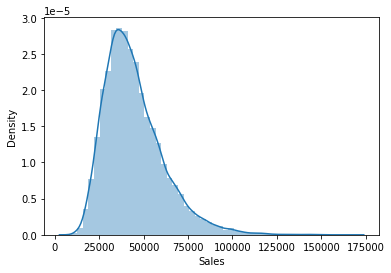

In [14]:
sns.distplot(sample['Sales'])